In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col

from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors

spark = SparkSession.Builder().appName('DDAM_Project_south').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 17:30:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/South_Incidents_Cleaned.csv')

Preparing data

In [3]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
#df_class.show()

In [4]:
colonne_booleane = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))

#df_class.show()


In [5]:
from pyspark.sql.functions import when, count, isnull
df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))

In [6]:
indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_Indexed")
df_class = indexer.fit(df_class).transform(df_class)

In [7]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_vector = OneHotEncoder(inputCol="Weather_Condition_Indexed", outputCol="Weather_Condition_1hot")
df_class = onehotencoder_vector.fit(df_class).transform(df_class)

In [8]:
df_class.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance_mi: double (nullable = true)
 |-- Temperature_F: double (nullable = true)
 |-- Humidity_perc: double (nullable = true)
 |-- Visibility_mi: double (nullable = true)
 |-- Wind_Speed_mph: double (nullable = true)
 |-- Precipitation_in: double (nullable = true)
 |-- Amenity: integer (nullable = true)
 |-- Bump: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Give_Way: integer (nullable = true)
 |-- Junction: integer (nullable = true)
 |-- No_Exit: integer (nullable = true)
 |-- Railway: integer (nullable = true)
 |-- Roundabout: integer (nullable = true)
 |-- Station: integer (nullable = true)
 |-- Stop: integer (nullable = true)
 |-- Traffic_Calming: integer (nullable = true)
 |-- Traffic_Signal: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Astronomical_Twilight: in

In [10]:
df_class=df_class.drop('Weather_Condition')
#df_class.show()


In [11]:
df_class=df_class.drop('Weather_Condition_Indexed')

In [12]:
num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Severity")
print(num_col)

['Start_Lat', 'Start_Lng', 'Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'month', 'hour', 'Astronomical_Twilight', 'Working_Weekend', 'Weather_Condition_1hot']


In [13]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_class)

classificationData = output_dataset.select("features", "Severity")

#classificationData.show(truncate=False)

In [14]:
classificationData= classificationData.withColumn("Severity", col("Severity") - 1)

In [15]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [16]:
from pyspark.sql import functions as F
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
#g.show()

In [17]:
g_p=g.toPandas()

In [32]:
g_p

,Severity,Count
0,0,3692
1,1,107932
2,2,8248
3,3,1952


In [18]:
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]
n_2=g_p.iloc[2,1]
n_3=g_p.iloc[3,1]

In [19]:
trainingData.show()

+--------------------+--------+
|            features|Severity|
+--------------------+--------+
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       3|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
+--------------------+--------+
only showing top 20 rows



In [18]:
testData.show()

+--------------------+--------+
|            features|Severity|
+--------------------+--------+
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
+--------------------+--------+
only showing top 20 rows



### Decision Tree con iperparametri di default

In [19]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

In [20]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(trainingData)

In [27]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.6612883663066517
hour con un'importanza dello 0.13902223753669454
month con un'importanza dello 0.13289372484121123
Traffic_Signal con un'importanza dello 0.035982162223901604
Working_Weekend con un'importanza dello 0.01536888202058574
Start_Lat con un'importanza dello 0.007937137878130142
Start_Lng con un'importanza dello 0.007507489192825154


In [36]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)

In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [38]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.9229729207710434
Test Error = 0.0770271


In [40]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 61.59%
Recall for class  0 : 68.47%
avg_F1-Score for class  0 : 64.85%
----------------------------
Precision for class  1 : 95.93%
Recall for class  1 : 96.83%
avg_F1-Score for class  1 : 96.38%
----------------------------
Precision for class  2 : 61.01%
Recall for class  2 : 65.41%
avg_F1-Score for class  2 : 63.13%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.6484944532488115, 0.9638170370932261, 0.6313180002754442, 0.0]
----------------------
avg_F1-Score: 56.09%


<Axes: >

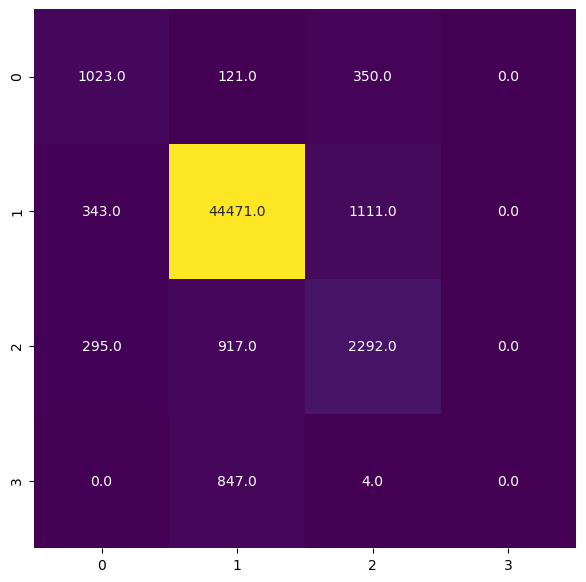

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Random Forest con iperparametri di default

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=10)


# Train model.  This also runs the indexers.
model = rf.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
#predictions.select("predictedLabel", "Severity", "features").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))


Test Accuracy = 0.886096


In [30]:
feat_imp=model.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.7161794022669217
month con un'importanza dello 0.0902938345147864
hour con un'importanza dello 0.05949296837218236
Temperature_F con un'importanza dello 0.0377976224280459
Start_Lat con un'importanza dello 0.028664947551425218
Start_Lng con un'importanza dello 0.023437960041040807
Working_Weekend con un'importanza dello 0.013914063882021318
Traffic_Signal con un'importanza dello 0.009887799826560876
Humidity_perc con un'importanza dello 0.00591918870079402
Astronomical_Twilight con un'importanza dello 0.004891380845628448
Crossing con un'importanza dello 0.002962839945416048
Wind_Speed_mph con un'importanza dello 0.002111943477993254
Stop con un'importanza dello 0.001604804797072646
Railway con un'importanza dello 0.0009717550563269034
Station con un'importanza dello 0.0007785520158302715
Visibility_mi con un'importanza dello 0.0004820087343897208
Precipitation_in con un'importanza dello 0.0003389

In [21]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 67.30%
Recall for class  0 : 23.56%
avg_F1-Score for class  0 : 34.90%
----------------------------
Precision for class  1 : 90.86%
Recall for class  1 : 99.29%
avg_F1-Score for class  1 : 94.89%
----------------------------
Precision for class  2 : 71.74%
Recall for class  2 : 21.80%
avg_F1-Score for class  2 : 33.44%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.34903321764997514, 0.9488612125563151, 0.33442766469687024, 0.0]
----------------------
avg_F1-Score: 40.81%


<Axes: >

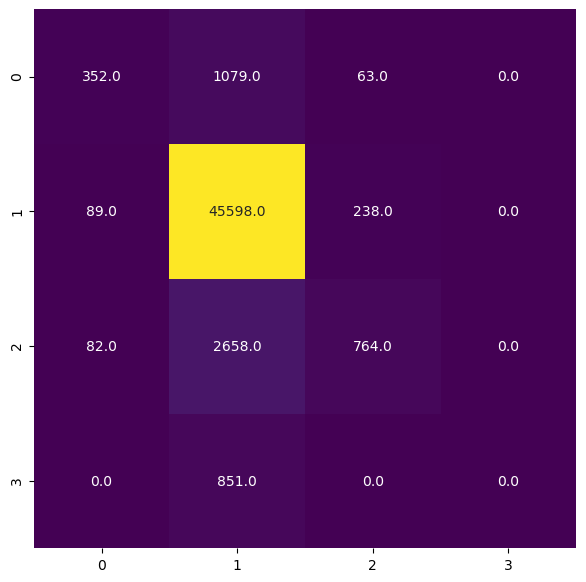

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Hyperparameter Tuning Decision Tree

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
n=trainingData.count()

In [21]:
max_depth=[5,15,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']

0.9223162204967744
Test Error = 0.0776838


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 57.70%
Recall for class  0 : 77.98%
avg_F1-Score for class  0 : 66.33%
----------------------------
Precision for class  1 : 95.92%
Recall for class  1 : 96.69%
avg_F1-Score for class  1 : 96.31%
----------------------------
Precision for class  2 : 63.01%
Recall for class  2 : 62.21%
avg_F1-Score for class  2 : 62.61%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.6632507828067179, 0.9630665799175885, 0.6260769672601953, 0.0]
----------------------
avg_F1-Score: 56.31%


<Axes: >

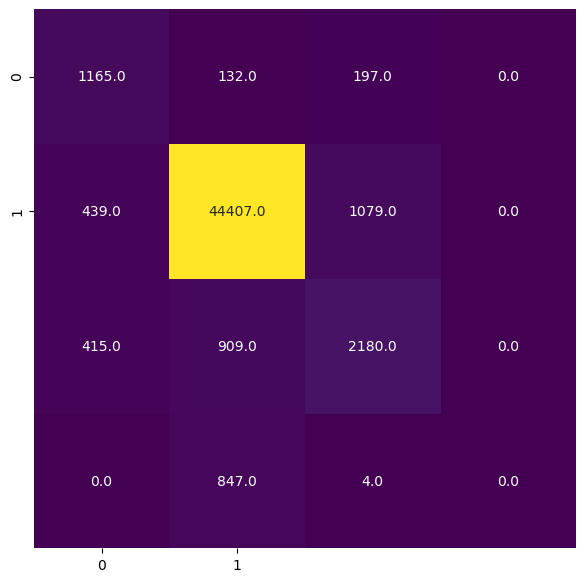

In [23]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=10, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [35]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.7747811581697881
month con un'importanza dello 0.11434358258175494
hour con un'importanza dello 0.07755385248187031
Traffic_Signal con un'importanza dello 0.020896767777655957
Start_Lat con un'importanza dello 0.009241995664636042
Start_Lng con un'importanza dello 0.0031826433242946356


In [ ]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=15, maxBins=32, 
                            minInstancesPerNode=round(0.02*n))
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [27]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.6612883663066517
hour con un'importanza dello 0.13902223753669454
month con un'importanza dello 0.13289372484121123
Traffic_Signal con un'importanza dello 0.035982162223901604
Working_Weekend con un'importanza dello 0.01536888202058574
Start_Lat con un'importanza dello 0.007937137878130142
Start_Lng con un'importanza dello 0.007507489192825154


0.9225093676362653
Test Error = 0.0774906


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 62.08%
Recall for class  0 : 69.81%
avg_F1-Score for class  0 : 65.72%
----------------------------
Precision for class  1 : 95.94%
Recall for class  1 : 96.68%
avg_F1-Score for class  1 : 96.31%
----------------------------
Precision for class  2 : 60.81%
Recall for class  2 : 66.15%
avg_F1-Score for class  2 : 63.37%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.6572148708254569, 0.9630722179444077, 0.6336796063422635, 0.0]
----------------------
avg_F1-Score: 56.35%


<Axes: >

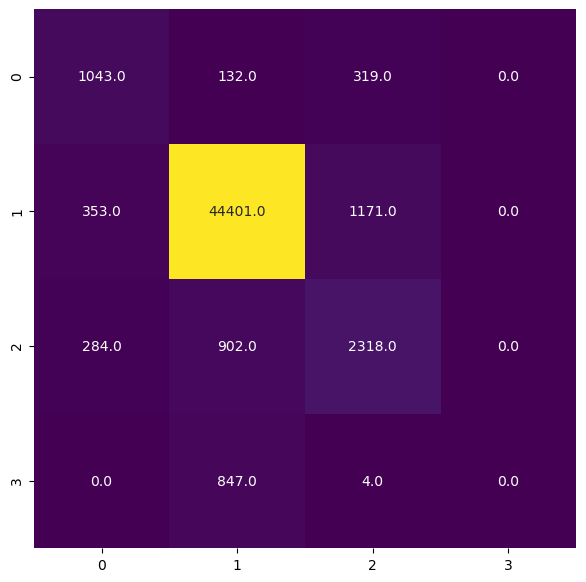

In [24]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=25, maxBins=64,
                            minInstancesPerNode=round(0.005*n), impurity='entropy' )
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [27]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.6612883663066517
hour con un'importanza dello 0.13902223753669454
month con un'importanza dello 0.13289372484121123
Traffic_Signal con un'importanza dello 0.035982162223901604
Working_Weekend con un'importanza dello 0.01536888202058574
Start_Lat con un'importanza dello 0.007937137878130142
Start_Lng con un'importanza dello 0.007507489192825154


0.5986595588519334
Test Error = 0.40134


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 52.88%
Recall for class  0 : 84.74%
avg_F1-Score for class  0 : 65.12%
----------------------------
Precision for class  1 : 98.94%
Recall for class  1 : 57.31%
avg_F1-Score for class  1 : 72.58%
----------------------------
Precision for class  2 : 42.31%
Recall for class  2 : 79.11%
avg_F1-Score for class  2 : 55.14%
----------------------------
Precision for class  3 : 3.93%
Recall for class  3 : 74.97%
avg_F1-Score for class  3 : 7.47%
----------------------------
[0.6512345679012346, 0.725781099192014, 0.5513674788662357, 0.07471163417061889]
----------------------
avg_F1-Score: 50.08%


<Axes: >

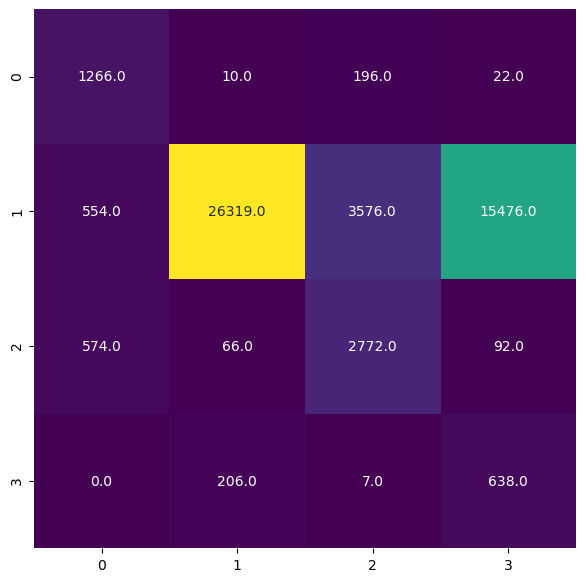

In [29]:
trainingData_w = trainingData.withColumn("weights", when(trainingData["Severity"] == 0 , n_1/n_0).when(trainingData["Severity"] == 1, 1)
    .when(trainingData["Severity"] == 2, n_1/n_2).when(trainingData["Severity"] == 3, n_1/n_3)

)

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=10, maxBins=32, 
                            minInstancesPerNode=round(0.02*n), weightCol='weights')
dt = dt.fit(trainingData_w)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [39]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.6121533885571321
hour con un'importanza dello 0.19393891740806393
month con un'importanza dello 0.12014492492903611
Start_Lat con un'importanza dello 0.05091408724838658
Start_Lng con un'importanza dello 0.017617420537750984
Humidity_perc con un'importanza dello 0.005231261319630373


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.7125391122957468
Test Error = 0.287461


Precision for class  0 : 46.49%
Recall for class  0 : 88.62%
avg_F1-Score for class  0 : 60.99%
----------------------------
Precision for class  1 : 98.61%
Recall for class  1 : 70.58%
avg_F1-Score for class  1 : 82.27%
----------------------------
Precision for class  2 : 47.96%
Recall for class  2 : 73.74%
avg_F1-Score for class  2 : 58.12%
----------------------------
Precision for class  3 : 5.33%
Recall for class  3 : 66.86%
avg_F1-Score for class  3 : 9.88%
----------------------------
[0.6098572086596038, 0.8227321183816437, 0.5811965811965812, 0.09880187532557737]
----------------------
avg_F1-Score: 52.81%


<Axes: >

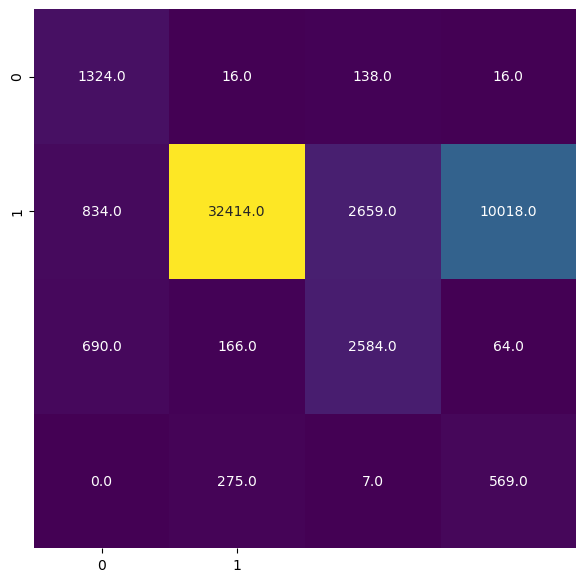

In [38]:
trainingData_w = trainingData.withColumn("weights", when(trainingData["Severity"] == 0 , n_1/n_0*0.5).when(trainingData["Severity"] == 1, 1)
    .when(trainingData["Severity"] == 2, n_1/n_2*0.5).when(trainingData["Severity"] == 3, n_1/n_3*0.7)

)

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=25, maxBins=64,
                            minInstancesPerNode=round(0.005*n), impurity='entropy', weightCol='weights' )
dt = dt.fit(trainingData_w)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [41]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.7147739237485864
month con un'importanza dello 0.11660536278525323
hour con un'importanza dello 0.07814397787664897
Start_Lat con un'importanza dello 0.04486030231841338
Start_Lng con un'importanza dello 0.03310587302500542
Traffic_Signal con un'importanza dello 0.006003467110928374
Junction con un'importanza dello 0.0018142425210296536
Wind_Speed_mph con un'importanza dello 0.0015118489985857853
Humidity_perc con un'importanza dello 0.0014603994263918695
Temperature_F con un'importanza dello 0.0011881936922712225
Working_Weekend con un'importanza dello 0.0005324084968857959


0.7009695986402441
Test Error = 0.29903


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 48.42%
Recall for class  0 : 89.16%
avg_F1-Score for class  0 : 62.76%
----------------------------
Precision for class  1 : 98.41%
Recall for class  1 : 69.35%
avg_F1-Score for class  1 : 81.36%
----------------------------
Precision for class  2 : 50.94%
Recall for class  2 : 72.43%
avg_F1-Score for class  2 : 59.82%
----------------------------
Precision for class  3 : 4.92%
Recall for class  3 : 67.57%
avg_F1-Score for class  3 : 9.18%
----------------------------
[0.6275618374558304, 0.8135961270709058, 0.5981616780579778, 0.09177972865123703]
----------------------
avg_F1-Score: 53.28%


<Axes: >

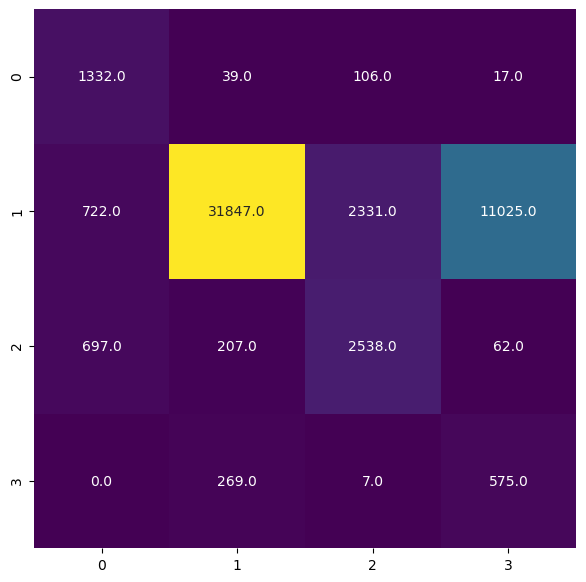

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 39754)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updates
   

In [42]:
trainingData_w = trainingData.withColumn("weights", when(trainingData["Severity"] == 0 , n_1/n_0*0.4).when(trainingData["Severity"] == 1, 1)
    .when(trainingData["Severity"] == 2, n_1/n_2*0.4).when(trainingData["Severity"] == 3, n_1/n_3*0.8)

)

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=15, maxBins=64,
                            minInstancesPerNode=round(0.005*n), weightCol='weights' )
dt = dt.fit(trainingData_w)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [43]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.572924799182621
hour con un'importanza dello 0.12643825081676635
month con un'importanza dello 0.10832896488943804
Start_Lat con un'importanza dello 0.0947573656725931
Start_Lng con un'importanza dello 0.06155956073097662
Traffic_Signal con un'importanza dello 0.017985559770060115
Humidity_perc con un'importanza dello 0.0062392211180105
Junction con un'importanza dello 0.005960122078013797
Wind_Speed_mph con un'importanza dello 0.004576102442835202
Temperature_F con un'importanza dello 0.0007607514520151893
Weather_Condition_1hot con un'importanza dello 0.0004693018466702224


### Hyperparameter Tuning Random Forest

Test Accuracy = 0.926314
Alberi :  5 maxDepth :  10


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 62.49%
Recall for class  0 : 73.03%
avg_F1-Score for class  0 : 67.35%
----------------------------
Precision for class  1 : 95.16%
Recall for class  1 : 97.64%
avg_F1-Score for class  1 : 96.39%
----------------------------
Precision for class  2 : 69.68%
Recall for class  2 : 57.79%
avg_F1-Score for class  2 : 63.18%
----------------------------
Precision for class  3 : 100.00%
Recall for class  3 : 0.12%
avg_F1-Score for class  3 : 0.23%
----------------------------
[0.6734567901234567, 0.9638673344367302, 0.6318252730109205, 0.0023474178403755865]
----------------------
avg_F1-Score: 56.79%


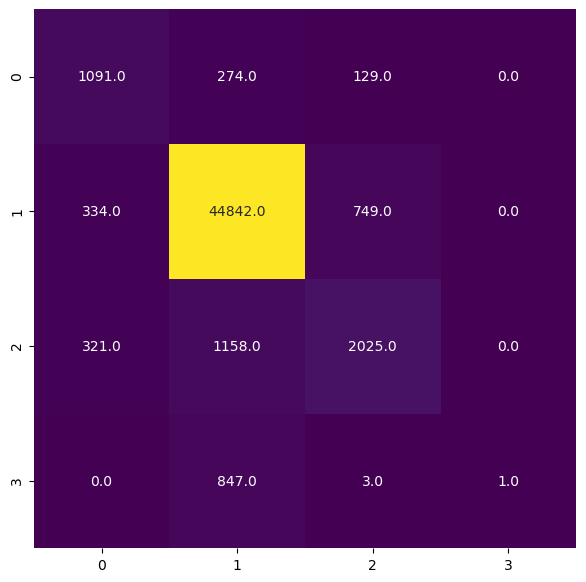

23/12/13 16:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB
23/12/13 16:18:12 WARN DAGScheduler: Broadcasting large task binary with size 1542.9 KiB
23/12/13 16:18:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/12/13 16:18:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/12/13 16:18:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/12/13 16:18:20 WARN DAGScheduler: Broadcasting large task binary with size 2025.7 KiB


Test Accuracy = 0.927898
Alberi :  5 maxDepth :  15


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/13 16:18:26 WARN DAGScheduler: Broadcasting large task binary with size 2013.4 KiB
23/12/13 16:18:26 WARN DAGScheduler: Broadcasting large task binary with size 2024.9 KiB


Precision for class  0 : 64.61%
Recall for class  0 : 72.36%
avg_F1-Score for class  0 : 68.27%
----------------------------
Precision for class  1 : 95.44%
Recall for class  1 : 97.41%
avg_F1-Score for class  1 : 96.42%
----------------------------
Precision for class  2 : 69.60%
Recall for class  2 : 62.93%
avg_F1-Score for class  2 : 66.10%
----------------------------
Precision for class  3 : 31.15%
Recall for class  3 : 2.23%
avg_F1-Score for class  3 : 4.17%
----------------------------
[0.682664982633407, 0.9641691002941906, 0.6609712230215826, 0.041666666666666664]
----------------------
avg_F1-Score: 58.74%


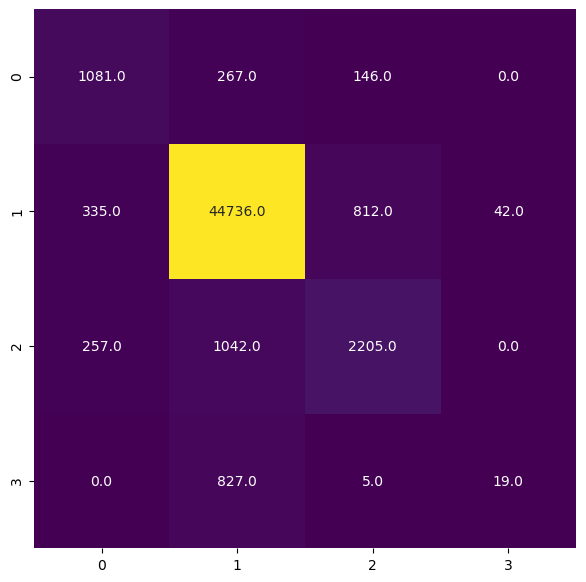

23/12/13 16:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB
23/12/13 16:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1542.9 KiB
23/12/13 16:18:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/12/13 16:18:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/12/13 16:19:02 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/12/13 16:19:09 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/12/13 16:19:12 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/12/13 16:19:18 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/12/13 16:19:25 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/12/13 16:19:33 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/12/13 16:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Test Accuracy = 0.927164
Alberi :  5 maxDepth :  20


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/13 16:20:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/12/13 16:20:05 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Precision for class  0 : 67.51%
Recall for class  0 : 71.62%
avg_F1-Score for class  0 : 69.50%
----------------------------
Precision for class  1 : 95.45%
Recall for class  1 : 97.23%
avg_F1-Score for class  1 : 96.33%
----------------------------
Precision for class  2 : 69.21%
Recall for class  2 : 63.90%
avg_F1-Score for class  2 : 66.45%
----------------------------
Precision for class  3 : 23.70%
Recall for class  3 : 4.82%
avg_F1-Score for class  3 : 8.01%
----------------------------
[0.6950308541734329, 0.9633249196384268, 0.6644902804570412, 0.080078125]
----------------------
avg_F1-Score: 60.07%


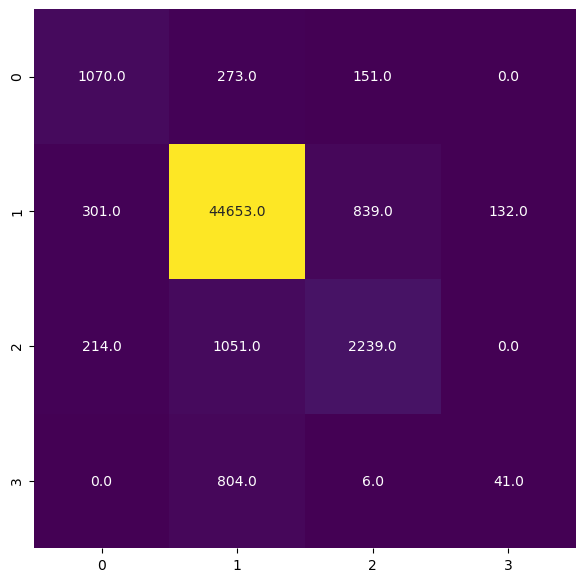

In [23]:
for maxDepth in range(10,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth= maxDepth) 
    # Addestra il modello sul set di dati sottocampionato
    model = rf.fit(trainingData) 
    predictions = model.transform(testData)
    evaluator = MulticlassClassificationEvaluator(
    labelCol="Severity", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test Accuracy = %g" % accuracy) 
    print("Alberi : ",5,"maxDepth : ",maxDepth)
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)

    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem

    avg_f1=sum_/4
    print('----------------------')

    print("avg_F1-Score: {:.2%}".format(avg_f1))
    import seaborn as sns
    import matplotlib.pyplot as plt
    labels = ["0", "1", "2", "3"]
    _ = plt.figure(figsize=(7, 7))
    sns.heatmap(metrics.confusionMatrix().toArray(),
                cmap='viridis',
                annot=True,fmt='0',
                cbar=False, 
                xticklabels=labels, 
                yticklabels=labels)
    plt.show()

### Grid Decision Tree

In [79]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

In [50]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

# Definiamo la Pipeline
#pipeline = Pipeline(stages=[dt])

In [51]:
n=df.count()

In [54]:
param_grid = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [5,10,15,20,25,30])
              .addGrid(dt.maxBins, [32, 64, 128])
              .addGrid(dt.minInstancesPerNode, [round(0.01*n),round(0.005*n),round(0.001*n),round(0.02*n)])
              .addGrid(dt.impurity, ['entropy', 'gini'])
              .build())

# Crea il CrossValidator
cross_validator = CrossValidator(estimator=dt,
                                 estimatorParamMaps=param_grid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol="Severity", 
                                                                             predictionCol="prediction", 
                                                                             metricName="accuracy"),
                                 numFolds=5,
                                 )

# Esegui la cross-validation e scegli il miglior set di parametri
cv_model = cross_validator.fit(trainingData)

# Ottieni il miglior modello dalla cross-validation
best_model = cv_model.bestModel

# Esegui predizioni sul set di test utilizzando il miglior modello
result = best_model.transform(testData)

# Valuta l'accuratezza sul set di test
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

accuracy = evaluator.evaluate(result)
print("Accuratezza sul set di test utilizzando il miglior modello = {:.2%}".format(accuracy))


Accuratezza sul set di test utilizzando il miglior modello = 92.65%
Migliori parametri:


AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'layers'

In [58]:
best_model.featureImportances

SparseVector(28, {0: 0.0297, 1: 0.0294, 2: 0.637, 19: 0.0456, 20: 0.1225, 21: 0.1358})

In [57]:
print(best_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a936a7752804, depth=9, numNodes=63, numClasses=5, numFeatures=28
  If (feature 2 <= 0.0015)
   If (feature 20 <= 4.5)
    If (feature 21 <= 11.5)
     If (feature 19 <= 0.5)
      If (feature 0 <= 32.485717)
       If (feature 1 <= -90.748863)
        Predict: 2.0
       Else (feature 1 > -90.748863)
        Predict: 3.0
      Else (feature 0 > 32.485717)
       If (feature 1 <= -109.906473)
        Predict: 2.0
       Else (feature 1 > -109.906473)
        If (feature 21 <= 8.5)
         If (feature 1 <= -97.12063549999999)
          Predict: 3.0
         Else (feature 1 > -97.12063549999999)
          If (feature 1 <= -96.7038785)
           Predict: 2.0
          Else (feature 1 > -96.7038785)
           Predict: 3.0
        Else (feature 21 > 8.5)
         Predict: 3.0
     Else (feature 19 > 0.5)
      Predict: 2.0
    Else (feature 21 > 11.5)
     If (feature 19 <= 0.5)
      If (feature 1 <= -97.557363)
       If (featu

In [60]:
result.select('prediction').distinct().collect()

[Row(prediction=1.0), Row(prediction=3.0), Row(prediction=2.0)]

In [63]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics


#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = result.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix())

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[1.0240e+03, 2.0900e+02, 2.6100e+02, 0.0000e+00],
             [3.3900e+02, 4.4585e+04, 1.0010e+03, 0.0000e+00],
             [2.4200e+02, 9.0200e+02, 2.3600e+03, 0.0000e+00],
             [0.0000e+00, 8.4700e+02, 4.0000e+00, 0.0000e+00]])


In [79]:
result_counts = result.groupBy("prediction").count()

# Stampare i risultati
result_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0| 1605|
|       3.0| 3626|
|       2.0|46543|
+----------+-----+



In [80]:
result_counts = result.groupBy("Severity").count()

# Stampare i risultati
result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1494|
|       3| 3504|
|       4|  851|
|       2|45925|
+--------+-----+



Dopo una grid search l'accuratezza aumenta leggermente da 92.19% a 92.65%. In ogni caso, la classe 4 non viene mai riconosciuta. TP per classe 2 e 3 sono più alti per la grid search, invece la classe 1 viene riconosciuta meglio dal dt base

#### Grid aggiungendo i pesi di ciascuna classe

In [80]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import lit

In [81]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

# Definiamo la Pipeline
#pipeline = Pipeline(stages=[dt])

In [82]:
n=df.count()

In [71]:
from pyspark.sql import functions as F
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g.sort('Count').show()

+--------+------+
|Severity| Count|
+--------+------+
|       4|  1933|
|       1|  3645|
|       3|  8207|
|       2|108039|
+--------+------+



In [69]:
trainingData = trainingData.withColumn("weights1", lit(1))#colonna con pesi tutti pari ad 1

In [74]:
# Creiamo la colonna 'weights' basata sulla frequenza delle classi
trainingData = trainingData.withColumn("weights2", when(trainingData["Severity"] == 0,n_1/n_0)#Calcolo del peso per la classe 0
    .when(trainingData["Severity"] == 1, 1)  # Calcolo del peso per la classe 1
    .when(trainingData["Severity"] == 2, n_1 / n_2)  # Calcolo del peso per la classe 2
    .when(trainingData["Severity"] == 3, n_1 / n_3)  # Calcolo del peso per la classe 3
)


In [75]:
trainingData = trainingData.withColumn("weights3", when(trainingData["Severity"] == 3,n_1 / n_3).otherwise(1))#teniamo solo il peso per la classe 3
#che non viene mai riconosciuta dal modello, alle altre lasciamo pesi pari ad 1



In [83]:
trainingData

DataFrame[features: vector, Severity: int, weights1: int, weights2: double, weights3: double]

In [86]:
param_grid = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [5,10,15,20,25,30])
              .addGrid(dt.maxBins, [32, 64, 128])
              .addGrid(dt.minInstancesPerNode, [round(0.01*n),round(0.005*n),round(0.001*n),round(0.02*n)])
              .addGrid(dt.weightCol, ['weights1','weights2','weights3'])
              .addGrid(dt.impurity, ['entropy', 'gini'])
              .build())

# Crea il CrossValidator
cross_validator = CrossValidator(estimator=dt,
                                 estimatorParamMaps=param_grid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol="Severity", 
                                                                             predictionCol="prediction", 
                                                                             metricName="accuracy"),
                                 numFolds=5,
                                 )

# Esegui la cross-validation e scegli il miglior set di parametri
cv_model = cross_validator.fit(trainingData)

# Ottieni il miglior modello dalla cross-validation
best_model = cv_model.bestModel

# Esegui predizioni sul set di test utilizzando il miglior modello
result = best_model.transform(testData)

# Valuta l'accuratezza sul set di test
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

accuracy = evaluator.evaluate(result)
print("Accuratezza sul set di test utilizzando il miglior modello = {:.2%}".format(accuracy))


23/12/08 16:35:09 WARN BlockManager: Asked to remove block broadcast_39998_piece0, which does not exist


Accuratezza sul set di test utilizzando il miglior modello = 92.48%


In [87]:
best_model.featureImportances

SparseVector(28, {0: 0.0147, 1: 0.0151, 2: 0.7566, 4: 0.0004, 19: 0.0286, 20: 0.1078, 21: 0.0768})

In [88]:
print(best_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_82ae68269034, depth=9, numNodes=59, numClasses=5, numFeatures=28
  If (feature 2 <= 0.0015)
   If (feature 20 <= 4.5)
    If (feature 21 <= 11.5)
     If (feature 19 <= 0.5)
      If (feature 0 <= 31.317270999999998)
       Predict: 2.0
      Else (feature 0 > 31.317270999999998)
       If (feature 1 <= -110.777632)
        Predict: 2.0
       Else (feature 1 > -110.777632)
        If (feature 21 <= 8.5)
         If (feature 1 <= -97.080408)
          Predict: 3.0
         Else (feature 1 > -97.080408)
          If (feature 1 <= -96.65978962734064)
           Predict: 2.0
          Else (feature 1 > -96.65978962734064)
           Predict: 3.0
        Else (feature 21 > 8.5)
         Predict: 3.0
     Else (feature 19 > 0.5)
      Predict: 2.0
    Else (feature 21 > 11.5)
     If (feature 19 <= 0.5)
      If (feature 1 <= -97.5204535)
       If (feature 0 <= 30.063663617672766)
        Predict: 3.0
       Else (feature 0 > 30.0

In [90]:
result.select('prediction').distinct().collect()

[Row(prediction=1.0), Row(prediction=3.0), Row(prediction=2.0)]

In [89]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics


#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = result.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix())

DenseMatrix([[1.1480e+03, 1.7800e+02, 2.1500e+02, 0.0000e+00],
             [3.9800e+02, 4.4463e+04, 9.5700e+02, 0.0000e+00],
             [3.4300e+02, 9.3200e+02, 2.2700e+03, 0.0000e+00],
             [2.0000e+00, 8.6600e+02, 2.0000e+00, 0.0000e+00]])


In [91]:
result_counts = result.groupBy("prediction").count()

# Stampare i risultati
result_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0| 1891|
|       3.0| 3444|
|       2.0|46439|
+----------+-----+



In [92]:
result_counts = result.groupBy("Severity").count()

# Stampare i risultati
result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1541|
|       3| 3545|
|       4|  870|
|       2|45818|
+--------+-----+



### Undersampling Decision Tree

Faccio una media delle occorrenze delle altre tre classi e riduco la classe di maggioranza a quel numero

In [44]:
und=(n_0+n_2+n_3)/3

In [45]:
train_und = trainingData.sampleBy('Severity', fractions={0:1.0 ,1: und/n_1 , 2:1.0, 3:1.0})

In [46]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(train_und)

In [47]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.5878387933407612
hour con un'importanza dello 0.18787016737761703
month con un'importanza dello 0.13517178917503334
Traffic_Signal con un'importanza dello 0.024515717507060573
Start_Lat con un'importanza dello 0.024461436818320137
Crossing con un'importanza dello 0.018810805473401394
Working_Weekend con un'importanza dello 0.016604658753093828
Start_Lng con un'importanza dello 0.004077988489718357
Visibility_mi con un'importanza dello 0.0006486430649941318


In [46]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [48]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.865453702630664
Test Error = 0.134546


In [49]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 49.77%
Recall for class  0 : 88.69%
avg_F1-Score for class  0 : 63.76%
----------------------------
Precision for class  1 : 97.83%
Recall for class  1 : 88.35%
avg_F1-Score for class  1 : 92.85%
----------------------------
Precision for class  2 : 46.50%
Recall for class  2 : 78.77%
avg_F1-Score for class  2 : 58.48%
----------------------------
Precision for class  3 : 8.80%
Recall for class  3 : 17.63%
avg_F1-Score for class  3 : 11.74%
----------------------------
[0.6376323387872954, 0.9284758058056912, 0.5848077126814282, 0.11737089201877934]
----------------------
avg_F1-Score: 56.71%


<Axes: >

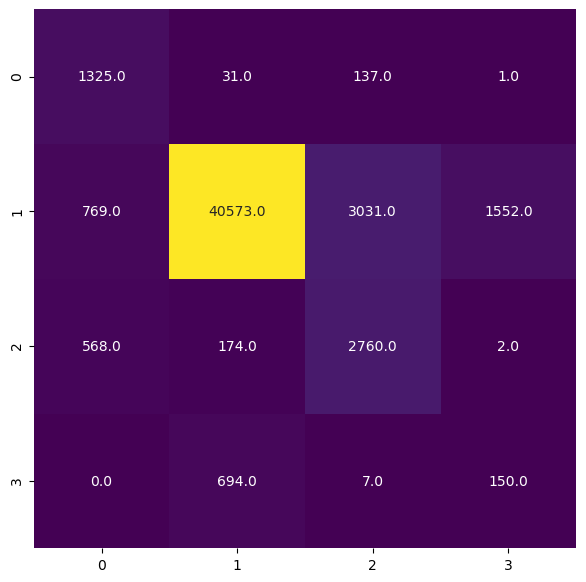

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Undersampling Random Forest

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=10)


# Train model.  This also runs the indexers.
model = rf.fit(train_und)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
#predictions.select("predictedLabel", "Severity", "features").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))


Test Accuracy = 0.902268


In [65]:
feat_imp=model.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    if el[0]>=24:
        print(num_col[len(num_col)-1], 'con un\'importanza dello', el[1])
    else:
        print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.5900640375889754
month con un'importanza dello 0.12415762396096944
hour con un'importanza dello 0.09638401485805824
Temperature_F con un'importanza dello 0.0352334093607984
Traffic_Signal con un'importanza dello 0.031787611478965055
Start_Lat con un'importanza dello 0.027430302669734525
Start_Lng con un'importanza dello 0.026479025985123562
Humidity_perc con un'importanza dello 0.021624336405664808
Crossing con un'importanza dello 0.017346098693595262
Wind_Speed_mph con un'importanza dello 0.010006743246720337
Working_Weekend con un'importanza dello 0.00963972645193331
Astronomical_Twilight con un'importanza dello 0.003736928173264075
Stop con un'importanza dello 0.0037191795365214184
Weather_Condition_1hot con un'importanza dello 0.0007675441854816697
Station con un'importanza dello 0.000503464959096789
Junction con un'importanza dello 0.0004385699601344944
Railway con un'importanza dello 0.00022

In [21]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 67.30%
Recall for class  0 : 23.56%
avg_F1-Score for class  0 : 34.90%
----------------------------
Precision for class  1 : 90.86%
Recall for class  1 : 99.29%
avg_F1-Score for class  1 : 94.89%
----------------------------
Precision for class  2 : 71.74%
Recall for class  2 : 21.80%
avg_F1-Score for class  2 : 33.44%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.34903321764997514, 0.9488612125563151, 0.33442766469687024, 0.0]
----------------------
avg_F1-Score: 40.81%


<Axes: >

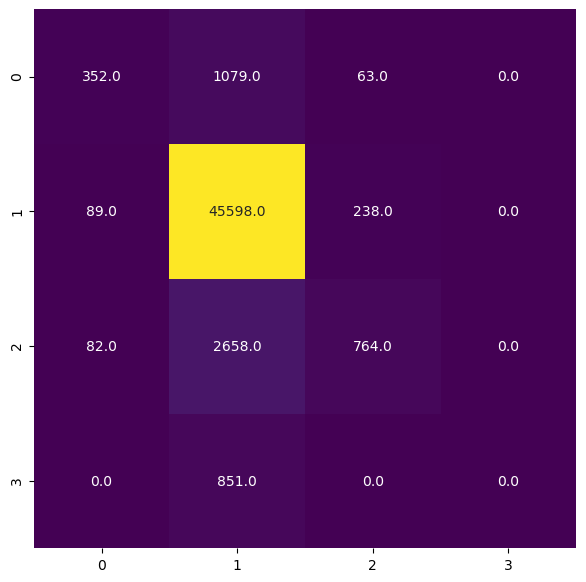

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test Accuracy = 0.835632
Alberi :  5 maxDepth :  10


Precision for class  0 : 55.23%
Recall for class  0 : 79.85%
avg_F1-Score for class  0 : 65.30%
----------------------------
Precision for class  1 : 98.20%
Recall for class  1 : 84.46%
avg_F1-Score for class  1 : 90.82%
----------------------------
Precision for class  2 : 45.27%
Recall for class  2 : 84.82%
avg_F1-Score for class  2 : 59.03%
----------------------------
Precision for class  3 : 8.76%
Recall for class  3 : 36.55%
avg_F1-Score for class  3 : 14.13%
----------------------------
[0.6529830322933772, 0.9081501252604716, 0.5903267454563512, 0.14126731773790596]
----------------------
avg_F1-Score: 57.32%


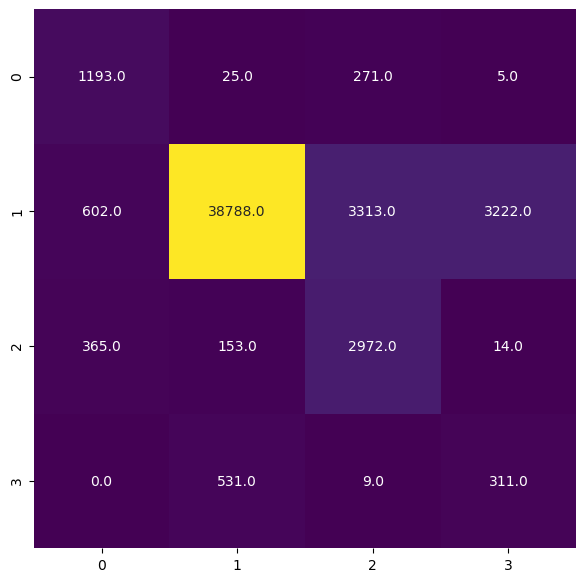

23/12/13 16:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
23/12/13 16:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1369.7 KiB
23/12/13 16:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1713.4 KiB
23/12/13 16:26:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/13 16:26:39 WARN DAGScheduler: Broadcasting large task binary with size 1350.9 KiB


Test Accuracy = 0.799417
Alberi :  5 maxDepth :  15


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/13 16:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1338.6 KiB
23/12/13 16:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1350.2 KiB


Precision for class  0 : 55.89%
Recall for class  0 : 82.26%
avg_F1-Score for class  0 : 66.56%
----------------------------
Precision for class  1 : 98.47%
Recall for class  1 : 79.95%
avg_F1-Score for class  1 : 88.25%
----------------------------
Precision for class  2 : 44.97%
Recall for class  2 : 86.02%
avg_F1-Score for class  2 : 59.06%
----------------------------
Precision for class  3 : 7.68%
Recall for class  3 : 50.41%
avg_F1-Score for class  3 : 13.33%
----------------------------
[0.6655835364202546, 0.8824823044476223, 0.5906329610033314, 0.13331261653200746]
----------------------
avg_F1-Score: 56.80%


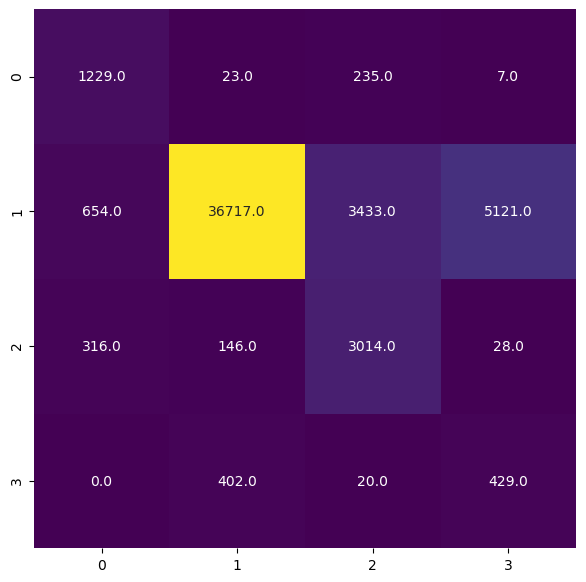

23/12/13 16:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
23/12/13 16:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1369.7 KiB
23/12/13 16:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1713.4 KiB
23/12/13 16:27:09 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/13 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/13 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/12/13 16:27:13 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/13 16:27:14 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/12/13 16:27:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/12/13 16:27:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.ge

Test Accuracy = 0.783868
Alberi :  5 maxDepth :  20


23/12/13 16:27:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Precision for class  0 : 55.35%
Recall for class  0 : 81.73%
avg_F1-Score for class  0 : 66.00%
----------------------------
Precision for class  1 : 98.57%
Recall for class  1 : 78.09%
avg_F1-Score for class  1 : 87.14%
----------------------------
Precision for class  2 : 44.14%
Recall for class  2 : 86.87%
avg_F1-Score for class  2 : 58.53%
----------------------------
Precision for class  3 : 7.27%
Recall for class  3 : 53.70%
avg_F1-Score for class  3 : 12.80%
----------------------------
[0.66, 0.8713992394513358, 0.5853283338140564, 0.1280470720089661]
----------------------
avg_F1-Score: 56.12%


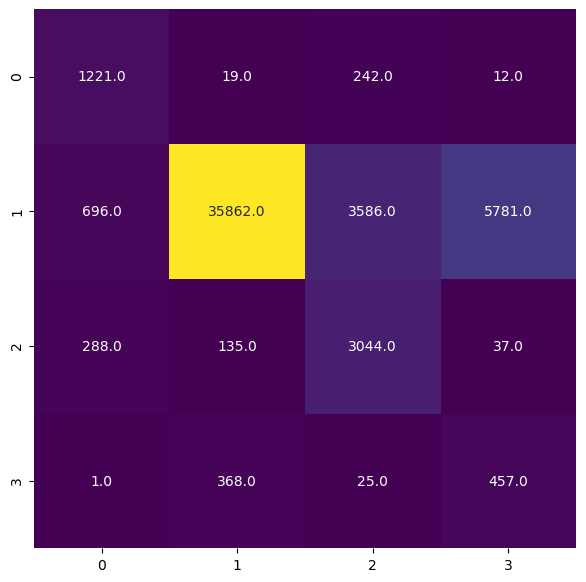

In [26]:
for maxDepth in range(10,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth= maxDepth) 
    # Addestra il modello sul set di dati sottocampionato
    model = rf.fit(train_und) 
    predictions = model.transform(testData)
    evaluator = MulticlassClassificationEvaluator(
    labelCol="Severity", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test Accuracy = %g" % accuracy) 
    print("Alberi : ",5,"maxDepth : ",maxDepth)
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)

    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem

    avg_f1=sum_/4
    print('----------------------')

    print("avg_F1-Score: {:.2%}".format(avg_f1))
    import seaborn as sns
    import matplotlib.pyplot as plt
    labels = ["0", "1", "2", "3"]
    _ = plt.figure(figsize=(7, 7))
    sns.heatmap(metrics.confusionMatrix().toArray(),
                cmap='viridis',
                annot=True,fmt='0',
                cbar=False, 
                xticklabels=labels, 
                yticklabels=labels)
    plt.show()

### Oversampling

In [51]:
trainingData_over=trainingData

In [21]:
for _ in range(10):
    trainingData_over = trainingData_over.unionAll(trainingData.filter(col('Severity') == 0))
    print(trainingData_over.count())

125516


129208


132900


ERROR:root:KeyboardInterrupt while sending command.               (0 + 32) / 45]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [22]:
trainingData_over = trainingData.unionAll(trainingData.filter(col('Severity') == 0))

In [30]:
trainingData_over.count()

125516

In [31]:
trainingData.count()+(36920)

158744

In [26]:
trainingData.filter(col('Severity') == 0).count()

3692

##### Oversampling per la classe 0

In [51]:
trainingData_over=trainingData
num_campioni_da_generare = n_1 - n_0
num_campioni_da_generare=num_campioni_da_generare/n_0 #percentuale 
print(num_campioni_da_generare)
full=trainingData.filter(col('Severity') == 0)
print(full.count())

while num_campioni_da_generare>1:
    full = full.unionAll(full)
    #trainingData_over = trainingData_over.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    #num_campioni_da_generare=num_campioni_da_generare/n_0
    #print(num_campioni_da_generare)
    #print('------')
    #print(trainingData_over.count())
print(num_campioni_da_generare, 'u')
df_minority_oversampled = full.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = full.unionAll(df_minority_oversampled)

28.234019501625134


3692


125516


129208


132900


136592


ERROR:root:KeyboardInterrupt while sending command.              (25 + 29) / 54]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [45]:
3692*28

103376

In [44]:
n_1

107932

In [42]:
(n_1-n_0)/n_0

28.234019501625134

In [48]:
trainingData_over.count()

23/12/11 15:11:06 WARN DAGScheduler: Broadcasting large task binary with size 1617.1 KiB


226074

In [66]:
prediction_counts = trainingData_over.groupBy("Severity").count()

# Stampare i risultati
prediction_counts.show()

23/12/09 14:21:43 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
ERROR:root:KeyboardInterrupt while sending command.              (0 + 32) / 648]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

##### Oversampling per la classe 2

In [ ]:
num_campioni_da_generare = n_1 - n_2
num_campioni_da_generare=num_campioni_da_generare/n_2 #percentuale 

while num_campioni_da_generare>1:
    df_minority_oversampled = df_spark.filter(col('classe') == 2).sample(True, 1.0, seed=42)
    trainingData = trainingData.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-n_2
    num_campioni_da_generare=num_campioni_da_generare/n_2

df_minority_oversampled = trainingData.filter(col('classe') == 2).sample(True, num_campioni_da_generare, seed=42)

trainingData = trainingData.unionAll(df_minority_oversampled)

##### Oversampling per la classe 4

In [ ]:
num_campioni_da_generare = n_1 - n_3
num_campioni_da_generare=num_campioni_da_generare/n_3 #percentuale 

while num_campioni_da_generare>1:
    df_minority_oversampled = df_spark.filter(col('classe') == 3).sample(True, 1.0, seed=42)
    trainingData = trainingData.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-n_3
    num_campioni_da_generare=num_campioni_da_generare/n_3

df_minority_oversampled = trainingData.filter(col('classe') == 3).sample(True, num_campioni_da_generare, seed=42)

trainingData = trainingData.unionAll(df_minority_oversampled)

In [22]:
oversample_0=trainingData.filter(col('Severity') == 0)
num_campioni_da_generare = n_1 - n_0
num_campioni_da_generare=num_campioni_da_generare/n_0 #percentuale 
#print(num_campioni_da_generare)
full_0=oversample_0
#print(full.count())

while num_campioni_da_generare>1:
    oversample_0 = oversample_0.unionAll(full_0)
    #trainingData_over = trainingData_over.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    #num_campioni_da_generare=num_campioni_da_generare/n_0
    print(num_campioni_da_generare)
    #print('------')
    #print(trainingData_over.count())
#print(num_campioni_da_generare, 'u')
df_minority_oversampled = full_0.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = full_0.unionAll(df_minority_oversampled)

27.234019501625134
26.234019501625134
25.234019501625134
24.234019501625134
23.234019501625134
22.234019501625134
21.234019501625134
20.234019501625134
19.234019501625134
18.234019501625134
17.234019501625134
16.234019501625134
15.234019501625134


23/12/11 18:12:06 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Cannot receive any reply from jupyter-c-2eandreazzoli1:45657 in 10000 milliseconds. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at scala.util.Failure.recover(Try.scala:234)
	at scala.concurrent.Future.$anonfun$recover$1(Future.scala:395)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at org.apache.spa

14.234019501625134
13.234019501625134
12.234019501625134
11.234019501625134
10.234019501625134
9.234019501625134
8.234019501625134
7.234019501625134
6.234019501625134
5.234019501625134
4.234019501625134
3.2340195016251343
2.2340195016251343
1.2340195016251343
0.2340195016251343


In [ ]:
oversample_2=trainingData.filter(col('Severity') == 2)
num_campioni_da_generare = n_1 - n_2
num_campioni_da_generare=num_campioni_da_generare/n_2 #percentuale 
#print(num_campioni_da_generare)
full_2=oversample_2
#print(full.count())

while num_campioni_da_generare>1:
    oversample_2 = oversample_2.unionAll(full_2)
    #trainingData_over = trainingData_over.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    #num_campioni_da_generare=num_campioni_da_generare/n_0
    print(num_campioni_da_generare)
    #print('------')
    #print(trainingData_over.count())
#print(num_campioni_da_generare, 'u')
df_minority_oversampled = full_2.sample(True, num_campioni_da_generare, seed=42)

oversample_2 = full_2.unionAll(df_minority_oversampled)

In [ ]:
trainingData_over=trainingData
num_campioni_da_generare = n_1 - n_3
num_campioni_da_generare=num_campioni_da_generare/n_3 #percentuale 
#print(num_campioni_da_generare)
full=trainingData.filter(col('Severity') == 3)
#print(full.count())

while num_campioni_da_generare>1:
    full = full.unionAll(full)
    #trainingData_over = trainingData_over.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    #num_campioni_da_generare=num_campioni_da_generare/n_0
    #print(num_campioni_da_generare)
    #print('------')
    #print(trainingData_over.count())
#print(num_campioni_da_generare, 'u')
df_minority_oversampled = full.sample(True, num_campioni_da_generare, seed=42)

oversample_3 = full.unionAll(df_minority_oversampled)

In [ ]:
df_oversampled=oversample_0.unionAll(oversample_2).unionAll(oversample_3).unionAll(trainingData.filter(col('Severity') == 1
                                                                                                      ))

### Decision Tree Mezzo

In [67]:
under_1=trainingData.filter(col('Severity') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [68]:
oversample_0=trainingData.filter(col('Severity') == 0)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_0)/n_0 #percentuale 
#print(num_campioni_da_generare)
full_0=oversample_0
#print(full.count())
while num_campioni_da_generare>1:
    oversample_0 = oversample_0.unionAll(full_0)
    #trainingData_over = trainingData_over.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    #num_campioni_da_generare=num_campioni_da_generare/n_0
    print(num_campioni_da_generare)
    #print('------')
    #print(trainingData_over.count())
#print(num_campioni_da_generare, 'u')
df_minority_oversampled = full_0.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = oversample_0.unionAll(df_minority_oversampled)

6.114402173913043
5.114402173913043
4.114402173913043
3.114402173913043
2.114402173913043
1.1144021739130432
0.11440217391304319


In [69]:
oversample_2=trainingData.filter(col('Severity') == 2)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_2)/n_2 #percentuale 
#print(num_campioni_da_generare)
full_2=oversample_2
#print(full.count())

while num_campioni_da_generare>1:
    oversample_2 = oversample_2.unionAll(full_2)
    #trainingData_over = trainingData_over.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    #num_campioni_da_generare=num_campioni_da_generare/n_0
    print(num_campioni_da_generare)
    #print('------')
    #print(trainingData_over.count())
#print(num_campioni_da_generare, 'u')
df_minority_oversampled = full_2.sample(True, num_campioni_da_generare, seed=42)

oversample_2 = oversample_2.unionAll(df_minority_oversampled)

1.6652755615564012
0.6652755615564012


In [70]:
oversample_3=trainingData.filter(col('Severity') == 3)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_3)/n_3 #percentuale 
#print(num_campioni_da_generare)
full_3=oversample_3
#print(full.count())

while num_campioni_da_generare>1:
    oversample_3 = oversample_3.unionAll(full_3)
    #trainingData_over = trainingData_over.unionAll(df_minority_oversampled)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    #num_campioni_da_generare=num_campioni_da_generare/n_0
    print(num_campioni_da_generare)
    #print('------')
    #print(trainingData_over.count())
#print(num_campioni_da_generare, 'u')
df_minority_oversampled = full_3.sample(True, num_campioni_da_generare, seed=42)

oversample_3 = oversample_3.unionAll(df_minority_oversampled)

13.066094853683149
12.066094853683149
11.066094853683149
10.066094853683149
9.066094853683149
8.066094853683149
7.066094853683149
6.066094853683149
5.066094853683149
4.066094853683149
3.0660948536831487
2.0660948536831487
1.0660948536831487
0.06609485368314871


In [71]:
df_mezzo=oversample_0.unionAll(oversample_2).unionAll(oversample_3).unionAll(under_1)

In [53]:
df_mezzo.count()

23/12/11 21:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1672.2 KiB


133639

In [55]:
from pyspark.sql import functions as F
g=df_mezzo.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g.show()

23/12/11 21:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1682.9 KiB


+--------+-----+
|Severity|Count|
+--------+-----+
|       0|33434|
|       1|32343|
|       2|34853|
|       3|33009|
+--------+-----+



In [72]:
train_mezzo=df_mezzo

In [73]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(train_mezzo)

23/12/16 17:57:18 WARN DAGScheduler: Broadcasting large task binary with size 1617.2 KiB
23/12/16 18:00:21 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:00:21 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:03:58 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:05:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:06:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:07:14 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:07:55 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:08:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


In [74]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.5880523912169244
hour con un'importanza dello 0.1947084125202182
month con un'importanza dello 0.12628916642521873
Start_Lat con un'importanza dello 0.029860234045226315
Crossing con un'importanza dello 0.020259465072310915
Working_Weekend con un'importanza dello 0.01752714265595271
Traffic_Signal con un'importanza dello 0.008377278835874769
Start_Lng con un'importanza dello 0.00800894476425396
Junction con un'importanza dello 0.0033188214244961756
Stop con un'importanza dello 0.0027416781144444053
Precipitation_in con un'importanza dello 0.0008564649250794217


In [60]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)

In [61]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [62]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.6422528682350215
Test Error = 0.357747


In [63]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 49.17%
Recall for class  0 : 88.76%
avg_F1-Score for class  0 : 63.28%
----------------------------
Precision for class  1 : 98.58%
Recall for class  1 : 62.28%
avg_F1-Score for class  1 : 76.33%
----------------------------
Precision for class  2 : 46.69%
Recall for class  2 : 78.51%
avg_F1-Score for class  2 : 58.56%
----------------------------
Precision for class  3 : 4.05%
Recall for class  3 : 67.45%
avg_F1-Score for class  3 : 7.64%
----------------------------
[0.6327845382963494, 0.7633345343421808, 0.5855683269476373, 0.07641107561235357]
----------------------
avg_F1-Score: 51.45%


<Axes: >

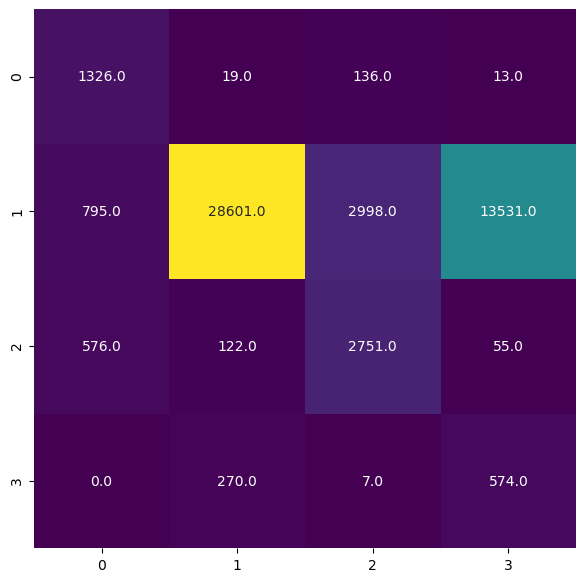

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Random Forest Mezzo

In [75]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=10)


# Train model.  This also runs the indexers.
model = rf.fit(train_mezzo)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
#predictions.select("predictedLabel", "Severity", "features").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))


23/12/16 18:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1617.2 KiB
23/12/16 18:14:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:14:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:18:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:21:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:24:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:25:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:25:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 18:26:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


Test Accuracy = 0.581093


In [76]:
feat_imp=model.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    if el[0]>=24:
        print(num_col[len(num_col)-1], 'con un\'importanza dello', el[1])
    else:
        print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.5559964791302766
hour con un'importanza dello 0.13726643485859308
month con un'importanza dello 0.08438605566732052
Temperature_F con un'importanza dello 0.05474006796802648
Start_Lng con un'importanza dello 0.038598627654546
Traffic_Signal con un'importanza dello 0.03575889785655264
Start_Lat con un'importanza dello 0.026843722710239076
Working_Weekend con un'importanza dello 0.016461399090782015
Humidity_perc con un'importanza dello 0.015204414571432146
Crossing con un'importanza dello 0.013176780634590601
Wind_Speed_mph con un'importanza dello 0.008631981234960534
Stop con un'importanza dello 0.004772077587448764
Astronomical_Twilight con un'importanza dello 0.003324110887141906
Junction con un'importanza dello 0.002801587740332875
Station con un'importanza dello 0.0014132321762760467
Weather_Condition_1hot con un'importanza dello 0.0001945314108614524
Precipitation_in con un'importanza dello 0

In [66]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 49.03%
Recall for class  0 : 88.02%
avg_F1-Score for class  0 : 62.98%
----------------------------
Precision for class  1 : 99.04%
Recall for class  1 : 51.85%
avg_F1-Score for class  1 : 68.07%
----------------------------
Precision for class  2 : 44.58%
Recall for class  2 : 79.74%
avg_F1-Score for class  2 : 57.18%
----------------------------
Precision for class  3 : 3.58%
Recall for class  3 : 78.97%
avg_F1-Score for class  3 : 6.85%
----------------------------
[0.6297892720306514, 0.6806631413462914, 0.5718379042161277, 0.06846663270504331]
----------------------
avg_F1-Score: 48.77%


<Axes: >

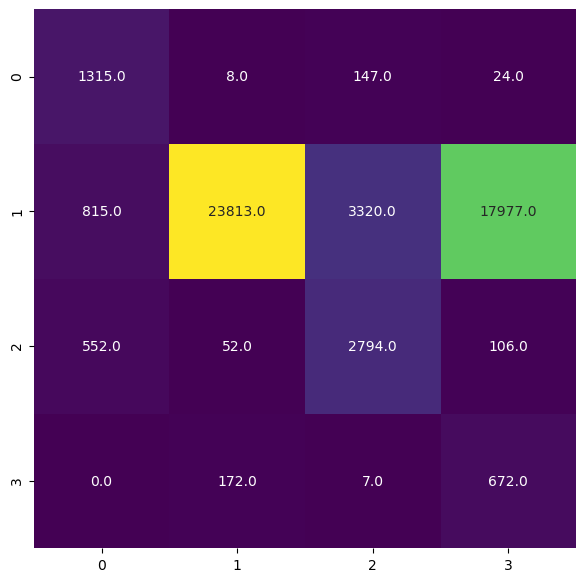

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 59048)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updates
   

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)